In [ ]:
# Install dependencies
!pip install pandas scikit-learn numpy matplotlib torch torchvision torchaudio transformers -q

In [ ]:
# --- Robust loader for True/Fake CSVs (case-insensitive, upload or disk) ---

from google.colab import files
import pandas as pd, io, os, glob

# 1) Let user pick files (safe to re-run; skips if nothing selected)
try:
    uploaded = files.upload()
except Exception:
    uploaded = {}

def _read_from_uploaded(uploaded_dict, target_keywords):
    # try to read from in-memory uploaded dict (no need to save to disk)
    for k in uploaded_dict.keys():
        kl = k.lower()
        if any(t in kl for t in target_keywords):
            return pd.read_csv(io.BytesIO(uploaded_dict[k]))
    return None

def _read_from_disk(target_keywords):
    # search current dir for likely matches
    patterns = []
    for t in target_keywords:
        patterns += [f"*{t}*.csv", f"*{t}*.CSV"]
    for p in patterns:
        matches = sorted(glob.glob(p))
        if matches:
            return pd.read_csv(matches[0])
    return None

def load_news_pair():
    # try uploaded first
    true_df = _read_from_uploaded(uploaded, ["true"])
    fake_df = _read_from_uploaded(uploaded, ["fake"])

    # if any missing, fall back to disk search
    if true_df is None:
        true_df = _read_from_disk(["true"])
    if fake_df is None:
        fake_df = _read_from_disk(["fake"])

    if true_df is None or fake_df is None:
        # show what's in the working dir to help diagnose
        print("Files in working dir:", os.listdir())
        raise FileNotFoundError(
            "Could not locate both CSVs. Make sure files contain 'true' and 'fake' in the name "
            "(any case), e.g., True.csv / Fake.csv or true.csv / fake_news.csv."
        )
    return true_df, fake_df

true_df, fake_df = load_news_pair()
print("✅ Loaded shapes:", true_df.shape, fake_df.shape)

# Add labels and continue as before
true_df['label'] = 1   # real
fake_df['label'] = 0   # fake

data = pd.concat([true_df, fake_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print("✅ Combined dataset:", data.shape)
data.head()

Saving true.csv to true (3).csv
Saving fake.csv to fake (3).csv
✅ Loaded shapes: (21417, 4) (23481, 4)
✅ Combined dataset: (44898, 5)


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [ ]:
# --- Preprocessing + TF-IDF vectorization before training ---

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Basic text cleaning ---
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))          # remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)            # keep only letters
    text = re.sub(r"\s+", " ", text)                  # collapse whitespace
    return text.lower().strip()

# Clean the text column (your combined dataframe from before)
data['clean_text'] = data['text'].apply(clean_text)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'],
    data['label'],
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("✅ Vectorization complete!")
print(f"Train shape: {X_train_vec.shape}, Test shape: {X_test_vec.shape}")

✅ Vectorization complete!
Train shape: (35918, 5000), Test shape: (8980, 5000)


Accuracy: 0.9868596881959911
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



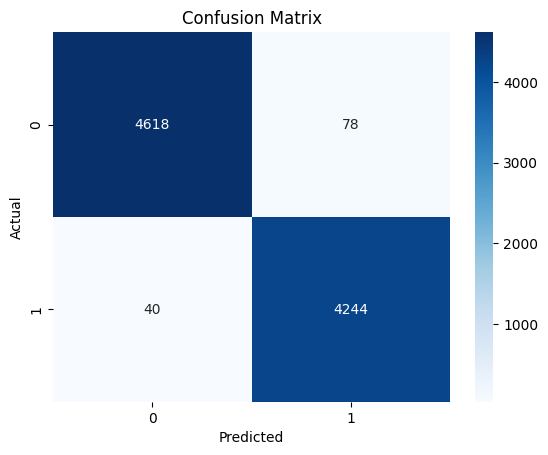

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# Evaluate
y_pred = clf.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix"); plt.show()

In [ ]:
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())
sorted_coef_index = clf.coef_[0].argsort()

top_fake = feature_names[sorted_coef_index[:20]]
top_real = feature_names[sorted_coef_index[-20:]]

print("🔴 Top words indicating FAKE news:")
print(top_fake)
print("\n🟢 Top words indicating REAL news:")
print(top_real)

🔴 Top words indicating FAKE news:
['just' 'read' 'image' 'featured' 'gop' 'wire' 'mr' 'com' 'hillary'
 'america' 'pic' 'getty' 'watch' 'like' 'sen' 'rep' 'obama' 'american'
 'didn' 'images']

🟢 Top words indicating REAL news:
['statement' 'saying' 'spokesman' 'representatives' 'edt' 'comment'
 'london' 'reporters' 'minister' 'presidential' 'monday' 'friday' 'nov'
 'republican' 'thursday' 'tuesday' 'wednesday' 'washington' 'said'
 'reuters']


In [ ]:
from transformers import pipeline

model = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

text = "President announces new economic reforms amid criticism from the opposition."
print(model(text))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9726589918136597}]


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", pos_label=1)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}\n")

# (Optional) full report
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.987
Precision: 0.98
Recall: 0.99
F1-score: 0.99

              precision    recall  f1-score   support

           0      0.991     0.983     0.987      4696
           1      0.982     0.991     0.986      4284

    accuracy                          0.987      8980
   macro avg      0.987     0.987     0.987      8980
weighted avg      0.987     0.987     0.987      8980

